# Phase Transitions in Magnets
### Christina Lee
### Category: Prerequisites
### Physics Prerequisites:  Statistical Mechanics

### Monte Carlo Physics Series
* [Monte Carlo: Calculation of Pi](../Numerics_Prog/Monte-Carlo-Pi.ipynb)
* [Monte Carlo Markov Chain](../Numerics_Prog/Monte-Carlo-Markov-Chain.ipynb)
* [Monte Carlo Ferromagnet](../Prerequisites/Monte-Carlo-Ferromagnet.ipynb)
* [Phase Transitions](../Prerequisites/Phase-Transitions.ipynb)

In Monte Carlo Ferromagnets, we only looked at the state of a magnet at one temperature.  While I displayed how it looked at both a high temperature and a low-temperature situation, that had to be done manually.  Today we are going to automate our study of temperature's effect.  

First off, what's the theory?  

The standard apparatus for phase transitions is <b>Landau Theory</b>.  In Landau theory, we assume that we have an <b>order parameter</b>. 

Order parameters have
* local physical meaning
* global observational consequences

For example, in magnets we use the local magnetization $m$; in freezing fluids, the difference in density $\rho$.  The value of an order parameter should undergo a jump across a phase transition, usually from a zero to a non-zero value.  

To construct Landau theory, we postulate that we can create a <b>Free Energy</b> for the system that is
* continuous in the order parameter
* respects the symmetries of the system

Given those constraints, we get
\begin{equation}
F=f_0(T) + \alpha_0 (T-T_c) m^2+ \frac{1}{2} \beta m^4 - h m + ...
\end{equation}
From this simple equation, we can derive many of the qualitative properties of phase transitions.  I won't repeat that here, but you can look it up in a Statistical Mechanics textbook.

Non-zero order parameters also represent symmetry breaking.  In an unmagnetized magnet, all directions are equivalent, but once it magnetizes, it chooses a preferred direction.  That direction is arbitrary up until the magnet spontaneously chooses it.  

Back in the early days of cars, streets didn't have lanes and a specified side for cars to drive on.  Driving was symmetric.   When two cars approached each other on the same road, the drivers had to figure out how to avoid a collision, either by everyone going to their left or everyone going to their right.  Eventually, all the cars in a specific area picked up one convention. In the United States, we choose the right side of the road.  In Japan, they chose left.  Neither is wrong; it was pure chance.  The solution breaks the symmetry of the problem.

![Symmetry Breaking](../Images/PhaseTransitions/symmetrybreaking.svg)

### Specific Heat and Magnetic Susceptibility

In addition to magnetization and energy, today I introduce the physical observables specific heat and magnetic susceptibility.  These numbers describe how the old quantities change with temperature.  

Let's take a look at the first one, <b>Specific Heat</b>:
\begin{equation}
C_h=\frac{d \langle E \rangle}{dT}
\end{equation}

While the above is the formal definition, we can calculate a more convenient expression by plugging in the Maxwell-Boltzmann Distribution:

\begin{equation}
\frac{ d
\frac{\sum_{i} E_{i} e^{-\beta E_i}}{ \sum_j e^{-\beta E_j} }
}{dT}=\beta^2 \left( \langle E^2 \rangle - \langle E \rangle ^2 \right)
\end{equation}

This equation we use to calculate the specific heat, as it uses the values calculated at only one temperature, eliminating the need for a numerical derivative.  For each temperature, we will need to calculate both the expectation of the Energy and the expectation of the Energy Squared.

While in general, a material may be difficult to describe, near phase transitions certain properties diverge according to corresponding <b>critical exponents</b>.  These fall out of the phenomenology of Landau theory, which you can find more about in a textbook.

These critical exponents obey <b>universality</b>.  Phase transitions in the same class will follow the same critical exponents.  Determining the exponent for the 2D square lattice through our simulations also determines the exponent for situations like the mixing of two materials or the percolation problem.

We define our specific heat critical exponent this way,
\begin{equation}
C_h \propto \left( T- T_c \right)^{-\alpha_{\pm}}.
\end{equation}

The divergent scaling of most properties around a critical temperature depends on the divergence of the <b>correlation length</b> $\xi$, the size of fluctuations in the system.  At the critical temperature, fluctuations exist at <i>every length scale</i>.   Once we get close enough to the transition temperature for the fluctuations to become greater than our finite simulation lattice, our computed numbers no longer agree with infinite-lattice-assumed theory.  The divergence gets modified by some function of the ratio between the correlation length and our system size,
\begin{equation}
C_h \propto \left( T - T_c \right)^{-\alpha_{\pm}} g\left( \frac{L}{\xi (T)} \right).
\end{equation}

Magnetic Susceptibility fulfills the same general role as specific heat, but for magnetization instead of energy.
\begin{equation}
\chi =\frac{d \langle M \rangle}{dT}=\beta^2 \left( \langle M^2 \rangle - \langle M \rangle ^2 \right)
\end{equation}

Again, this property also has a corresponding critical exponent.
\begin{equation}
\chi \propto \left( T - T_c \right)^{-\gamma_{\pm}}
\end{equation}

## Exact Solution

The 2D Square Ising model possesses an exact solution, first discovered by Lars Onsager in 1944, but since rewritten in a variety of different ways.  I won't go over how to achieve the solution, but I will show the results for comparison.

The critical temperature:
\begin{equation}
J \beta_c= \frac{\ln \left( \sqrt{2}+1 \right)}{2} \approx .4406
\end{equation}

\begin{equation}
T_c \approx 2.269 J
\end{equation}

The magnetization curve when $T<T_c$ also $\beta > \beta_c$
\begin{equation}
M=\left(1-\sinh^{-4} \left(2 \beta J \right) \right)^{1/8}
\end{equation}

And finally, the much more complicated expression for internal energy per site,

\begin{equation}
k=\sinh (2 \beta J)^{-2}
\end{equation}

\begin{equation}
U=-J \coth (2 \beta J) \left(
1 + \frac{2}{\pi} \left( 2 \tanh^2 (2 \beta J) - 1 \right)
\int_0^{\pi/2} \frac{1}{\sqrt{1-4k (1+k)^{-2} \sin^2 (\theta)}}
d \theta
\right)
\end{equation}

If we can achieve these results to perfect accuracy on pen and paper, why do we even bother simulating them in a computer?  If you try some other lattices and coupling constants, you might soon find out why.  We want to make <i>sure</i> our code is running well on something where we know the results before venturing into unknown territory.    

Load our packages.  

`Lattices.jl` is the same class I used in the previous post. 

In [1]:
push!(LOAD_PATH,"../Packages")
using Lattices;
using Statistics
using QuadGK
using DelimitedFiles
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
# The critical inverse temperature
betac=log(1+sqrt(2))/2

# The exact magnetization
# Note: Does not take arrays
function Mexact(beta::Float64)
    if beta>betac
        return (1-sinh(2*beta*J)^(-4.0))^(1.0 ./8.0)
    else 
        return 0
    end
end

# The exact energy
# Note: Does not take arrays
function Eexact(beta::Float64)
    k=sinh(2*beta*J)^(-2.0)
    
    # the inside of the integral.  Define a function so we can use quadgk
    insides(θ)=(1-4*k*(1+k)^(-2)*sin(θ)^2)^(-0.5)
    #we run a numerical integration
    integ=quadgk(insides,0,π/2)[1]
    
    return -J*coth(2*beta*J)*(1+2/π*(2*tanh(2*beta*J)^2-1)*integ )
end

Eexact (generic function with 1 method)

Here we set up our lattice.

If looking for a mind bender, look at a `"Checkerboard"`, with an anti-ferromagnetic coupling constant, like `J=-1`.  Otherwise, just stick with a square.  

In [3]:
## Define l here
l=10;

lt=MakeLattice("Square",l);
S=ones(Int8,l,l);  #Our spins
dt=1/(lt.N);

Same as last time.  

These functions calculate properties of our lattice.

In [4]:
# The energy contribution of just one site
function dE(i::Int)
    Eii=0;
    for j in 1:lt.nnei
        Eii+=S[lt.neigh[i,j]];
    end
    Eii*=-J*S[i];  # we are computing J sz_i sz_j for one i
    return Eii;
end
# The energy of the entire lattice
function E()
    Evar=0;
    for k in 1:lt.N
        Evar+=.5*dE(k);
    end
    return Evar;
end
# The magnetization of the entire lattice
function M()
    Mvar=0;
    for k in 1:lt.N
        Mvar+=S[k];
    end
    return Mvar;
end
"defined functions"

"defined functions"

### Adjustable Parameters

In [5]:
beta0=.1;
betaf=1;
dbeta = .1 ; # coarse grained for faster computation
# dbeta=.025; # fine grained if you have a faster computer

J=1;
t=100000;
nskip=10;   # don't measure every sweep= better decorrelation
"Parameters set"

"Parameters set"

In [6]:
nmeas=Int64(t/nskip); # how many times we will measure
betas=collect(beta0:dbeta:betaf)
"done"

"done"

### Exact Solution Data Points

In [7]:
Mex=zeros(length(betas))
Eex=zeros(length(betas))
for ii in 1:length(betas)
    Mex[ii]=Mexact(betas[ii])
    Eex[ii]=Eexact(betas[ii])
end

I took what we ran last time and wrapped it into a function, `MCMCMagnet`.  We aren't looking at spin configurations this time; we only want the final measureables, which get returned at the end.

In [8]:
function MCMCMagnet(beta::Float64)
    tm=1; #Our measurement time step
    
    Ma=Array{Int32}(undef,nmeas); # our magnetization measurements
    Ea=Array{Int32}(undef,nmeas); # our energy measurements
    Ma2=Array{Int32}(undef,nmeas); # magnetization squared
    Ea2=Array{Int32}(undef,nmeas); # energy squared
    
    for ti in 1:t
        for j in 1:lt.N
            i = rand(1:lt.N); #Choosing a random site
            de=dE(i);
            if(de>0 || rand()<exp(2*beta*de) ) 
                S[i]=-S[i]; #Switch the sign
            end
        end
        if isapprox(mod(ti,nskip),0)
            Ma[tm]=M();
            Ma2[tm]=Ma[tm]^2;
            
            Ea[tm]=E();
            Ea2[tm]=Ea[tm]^2;
            
            tm+=1;

        end
    end
    Mave=mean(Ma);
    Mstd=std(Ma)/lt.N;
    Eave=mean(Ea);
    Estd=std(Ea)/lt.N;
    
    E2ave=mean(Ea2);
    M2ave=mean(Ma2);
    
    Ch=beta^2*(E2ave-Eave^2)/lt.N;
    χ=beta*(M2ave-Mave^2)/lt.N;
    
    return Mave/lt.N,Mstd,Eave/lt.N,Estd,Ch,χ
end

MCMCMagnet (generic function with 1 method)

# The Temperature Loop

This cell looks pretty simple: initialization and one for loop.  But this is where everything ties together.  

In [9]:
Mm=zeros(length(betas))
Mstd=zeros(length(betas))
Ee=zeros(length(betas))
Estd=zeros(length(betas))
Ch=zeros(length(betas))
χ=zeros(length(betas))
for ii in 1:length(betas)
    Mm[ii],Mstd[ii],Ee[ii],Estd[ii],Ch[ii],χ[ii]=MCMCMagnet(betas[ii])
    println("beta: ",betas[ii],"\tM: ",Mm[ii],"\tE: ",Ee[ii])
end

beta: 0.1	M: -0.001804	E: -0.203736
beta: 0.2	M: -0.000968	E: -0.428008
beta: 0.3	M: 0.0013059999999999999	E: -0.706624
beta: 0.4	M: -0.00808	E: -1.186944
beta: 0.5	M: 0.32823399999999997	E: -1.7440280000000001
beta: 0.6	M: 0.973302	E: -1.908696
beta: 0.7	M: 0.9904219999999999	E: -1.964804
beta: 0.8	M: 0.9960840000000001	E: -1.984992
beta: 0.9	M: 0.9984439999999999	E: -1.99392
beta: 1.0	M: 0.999256	E: -1.9971


That was the temperature loop for the MCMC method.  

### Storing and Restoring Data

Since running these simulations take slightly longer than some of my previous posts, I've outputed data files of the results of three different sizes lattices (l=10, l=20, l=50), for runs of length 100,000. Feel free to take a look at them, or make your own data :)

In [10]:
# if you want to write a new set of data
writedlm(string("PhaseTransitionsL",l,"t",t,"dbeta",dbeta,".dat"),[betas Mm Mstd Ee Estd Ch χ])

In [11]:
temp=readdlm("PhaseTransitionsL50t100000dbeta0.025.dat")
betas50=temp[:,1];
Mm50=temp[:,2];
Mstd50=temp[:,3];
Ee50=temp[:,4];
Estd50=temp[:,5];
Ch50=temp[:,6];
χ50=temp[:,7];

temp=readdlm("PhaseTransitionsL10t100000dbeta0.025.dat")
betas10=temp[:,1];
Mm10=temp[:,2];
Mstd10=temp[:,3];
Ee10=temp[:,4];
Estd10=temp[:,5];
Ch10=temp[:,6];
χ10=temp[:,7];

temp=readdlm("PhaseTransitionsL20t100000dbeta0.025.dat")
betas20=temp[:,1];
Mm20=temp[:,2];
Mstd20=temp[:,3];
Ee20=temp[:,4];
Estd20=temp[:,5];
Ch20=temp[:,6];
χ20=temp[:,7];

# Plotting Section

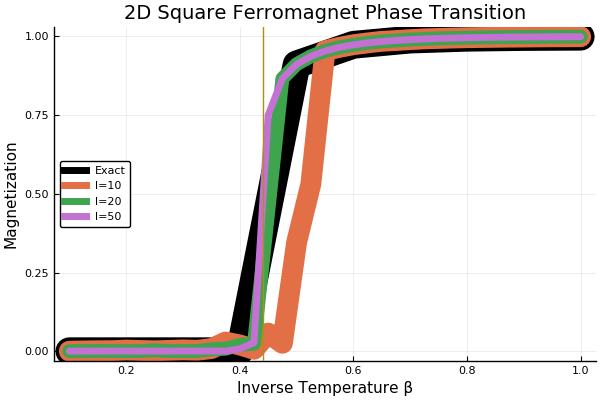

In [12]:
plot(betas,Mex,label="Exact",linewidth=20,color=:black)
plot!(betas10,abs.(Mm10),label="l=10",linewidth=15)
plot!(betas20,abs.(Mm20),label="l=20",linewidth=10)
plot!(betas50,abs.(Mm50),label="l=50",linewidth=5)

vline!([betac],label="")
plot!(xlabel="Inverse Temperature β",ylabel="Magnetization",
        title="2D Square Ferromagnet Phase Transition",legend=:left)

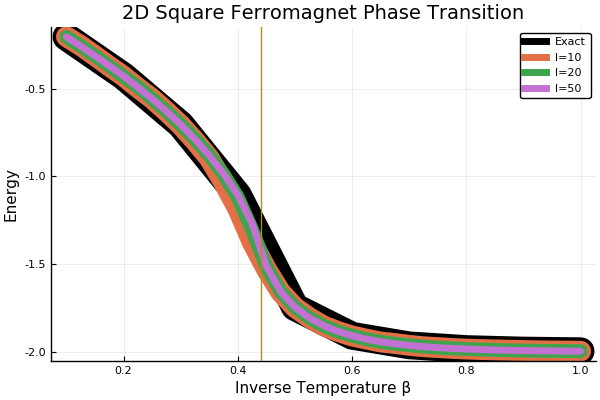

In [13]:
plot(betas,Eex,label="Exact",linewidth=20,color=:black)
plot!(betas10,Ee10,label="l=10",linewidth=15)
plot!(betas20,Ee20,label="l=20",linewidth=10)
plot!(betas50,Ee50,label="l=50",linewidth=5)

vline!([betac],label="")
plot!(xlabel="Inverse Temperature β",ylabel="Energy",
        title="2D Square Ferromagnet Phase Transition")

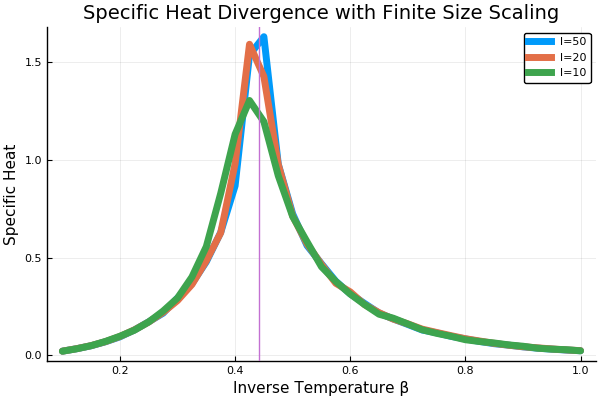

In [14]:
plot(betas50,Ch50,label="l=50",linewidth=5)
plot!(betas20,Ch20,label="l=20",linewidth=5)
plot!(betas10,Ch10,label="l=10",linewidth=5)


vline!([betac],label="")
plot!(xlabel="Inverse Temperature β",ylabel="Specific Heat",
    title="Specific Heat Divergence with Finite Size Scaling")

I presented two different equivalent formulas for the specific heat.  Let's check to make sure they're equivalent.  

For the formal defination, we'll take a numeric derivative with respect to $\beta$,
\begin{equation}
\frac{d \langle E \rangle}{dT} \approx \frac{ \Delta \langle E \rangle}{\Delta \beta}\frac{d \beta}{d T}
\end{equation}

Note: I corrected the scaling by hand.

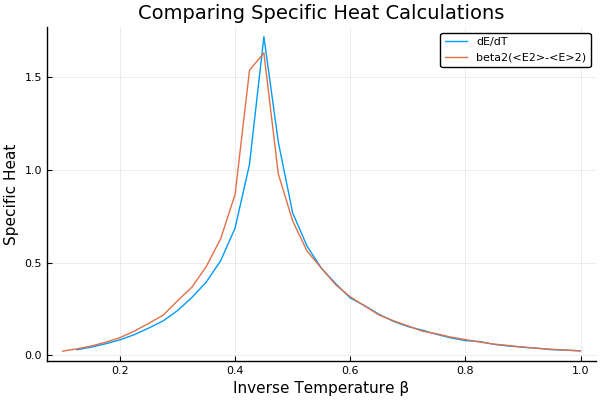

In [15]:
Ch2=(Ee50[1:end-1]-Ee50[2:end]).*betas50[2:end].^2
plot(betas50[2:end],Ch2*35,label="dE/dT")
plot!(betas50,Ch50,label="beta2(<E2>-<E>2)")

plot!(xlabel="Inverse Temperature β",ylabel="Specific Heat",
    title="Comparing Specific Heat Calculations")

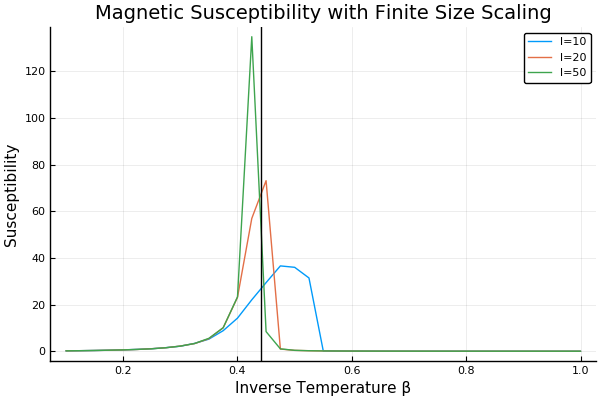

In [16]:
plot(betas10,χ10,label="l=10")
plot!(betas20,χ20,label="l=20")
plot!(betas50,χ50,label="l=50")

vline!([betac],label="",linecolor=:black)

plot!(xlabel="Inverse Temperature β",ylabel="Susceptibility",
    title="Magnetic Susceptibility with Finite Size Scaling")

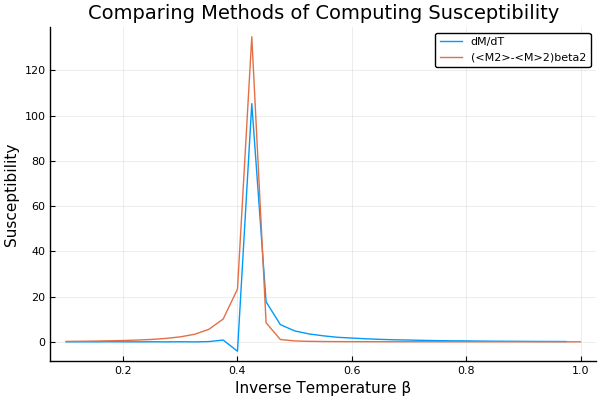

In [17]:
M2=(Mm50[2:end]-Mm50[1:end-1]).*(betas50[1:end-1]).^2
plot(betas50[1:end-1],M2*750,label="dM/dT")
plot!(betas50,χ50,label="(<M2>-<M>2)beta2")
plot!(xlabel="Inverse Temperature β",ylabel="Susceptibility",
    title="Comparing Methods of Computing Susceptibility")

That's all for now.  Plenty more to talk about on this subject, but hopefully that can keep you occupied.  
My plots are saved in M4/Images/PhaseTransitions .